In [1]:
import collections
import sys
import os
import re
import time
import numpy as np
import pandas as pd

In [2]:
class StubLogger(object):
    def __getattr__(self, name):
        return self.log_print

    def log_print(self, msg, *args):
        print(msg % args)

LOGGER = StubLogger()
LOGGER.info("Hello %s!", "world")

Hello world!


In [3]:
import contextlib
import time

@contextlib.contextmanager
def elapsed_timer(message):
    start_time = time.time()
    yield
    LOGGER.info(message.format(time.time() - start_time))

# Evaluation mechanism

Evaluation Functions

In [4]:
def hitsAtK(user_ranks, k=10):
    return (user_ranks["rank"].notna() & (user_ranks["rank"] <= k)).sum(skipna=True)


def precisionAtK(user_ranks, k):
    precision = float(hitsAtK(user_ranks, k)) / k
    return precision


def recallAtK(user_ranks, k):
    recall = float(hitsAtK(user_ranks, k)) / user_ranks.shape[0]
    return recall


def averagePrecisionAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_correct_user_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]

    if k_correct_user_ranks.shape[0] > 0:
        #print k_correct_user_ranks
        score = 0.0
        for row in range(k_correct_user_ranks.shape[0]):
            tmp_user_ranks = k_correct_user_ranks.head(row + 1)
            row_k = k_correct_user_ranks.iloc[row]["rank"]
            score = score + precisionAtK(tmp_user_ranks, row_k)
        avgPrec = float(score) / min(user_ranks.shape[0], k)
    else:
        avgPrec = 0.0
    return avgPrec


def ndcgAtK(user_ranks, k):
    def dcg(rank):
        return 1.0 / np.log2(rank + 1)


    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    k_ranks = k_user_ranks[k_user_ranks["rank"].notna() & (k_user_ranks["rank"] <= k)]["rank"].values

    ranks_idcg = dcg(np.arange(1, k_user_ranks.shape[0] + 1))
    ranks_dcg = dcg(k_ranks)

    ndcg = float(np.sum(ranks_dcg)) / np.sum(ranks_idcg)
    return ndcg


def topEventsAtK(user_ranks, k):
    user_ranks = user_ranks.sort_values(by="rank")
    k_user_ranks = user_ranks.head(min(user_ranks.shape[0], k))
    return pd.DataFrame({
        "event_id": k_user_ranks["event_id"].drop_duplicates().sort_values()
    })

In [5]:
def quickMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
    })


def basicMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
    })


def quadMetricsPerUser(user_ranks):
    return pd.DataFrame({
        "precision_at_50": [precisionAtK(user_ranks, 50)],
        "precision_at_20": [precisionAtK(user_ranks, 20)],
        "precision_at_10": [precisionAtK(user_ranks, 10)],
        "precision_at_5": [precisionAtK(user_ranks, 5)],
        "recall_at_50": [recallAtK(user_ranks, 50)],
        "recall_at_20": [recallAtK(user_ranks, 20)],
        "recall_at_10": [recallAtK(user_ranks, 10)],
        "recall_at_5": [recallAtK(user_ranks, 5)],
        "ndcg_at_50": [ndcgAtK(user_ranks, 50)],
        "ndcg_at_20": [ndcgAtK(user_ranks, 20)],
        "ndcg_at_10": [ndcgAtK(user_ranks, 10)],
        "ndcg_at_5": [ndcgAtK(user_ranks, 5)],
        "avg_prec_at_20": [averagePrecisionAtK(user_ranks, 20)],
        "avg_prec_at_10": [averagePrecisionAtK(user_ranks, 10)],
        "avg_prec_at_5": [averagePrecisionAtK(user_ranks, 5)],
    })

In [6]:
def evalMetrics(rank_data, *, runMetricsPerUser=None):
    if runMetricsPerUser is None:
        runMetricsPerUser = quadMetricsPerUser

    user_metrics = rank_data.groupby("user_id").apply(runMetricsPerUser)
    top_events_at_10 = rank_data.groupby("user_id").apply(topEventsAtK, 10)
    top_events_at_20 = rank_data.groupby("user_id").apply(topEventsAtK, 20)

    metrics = dict()
    # Precision
    if "precision_at_50" in user_metrics.columns:
        precision_50 = user_metrics["precision_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_50"] = [precision_50]
    if "precision_at_20" in user_metrics.columns:
        precision_20 = user_metrics["precision_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_20"] = [precision_20]
    if "precision_at_10" in user_metrics.columns:
        precision_10 = user_metrics["precision_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_10"] = [precision_10]
    if "precision_at_5" in user_metrics.columns:
        precision_5 = user_metrics["precision_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["precision_at_5"] = [precision_5]

    # Recall
    if "recall_at_50" in user_metrics.columns:
        recall_50 = user_metrics["recall_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_50"] = [recall_50]
    if "recall_at_20" in user_metrics.columns:
        recall_20 = user_metrics["recall_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_20"] = [recall_20]
    if "recall_at_10" in user_metrics.columns:
        recall_10 = user_metrics["recall_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_10"] = [recall_10]
    if "recall_at_5" in user_metrics.columns:
        recall_5 = user_metrics["recall_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["recall_at_5"] = [recall_5]

    # F1 Score
    if "precision_at_50" in user_metrics.columns and "recall_at_50" in user_metrics.columns:
        if precision_50 + recall_50 > 0:
            f1_score_50 =  2 * ((precision_50 * recall_50) / (precision_50 + recall_50))
        else:
            f1_score_50 = 0.0
        metrics["f1_score_at_50"] = [f1_score_50]
    if "precision_at_20" in user_metrics.columns and "recall_at_20" in user_metrics.columns:
        if precision_20 + recall_20 > 0:
            f1_score_20 =  2 * ((precision_20 * recall_20) / (precision_20 + recall_20))
        else:
            f1_score_20 = 0.0
        metrics["f1_score_at_20"] = [f1_score_20]
    if "precision_at_10" in user_metrics.columns and "recall_at_10" in user_metrics.columns:
        if precision_10 + recall_10 > 0:
            f1_score_10 =  2 * ((precision_10 * recall_10) / (precision_10 + recall_10))
        else:
            f1_score_10 = 0.0
        metrics["f1_score_at_10"] = [f1_score_10]
    if "precision_at_5" in user_metrics.columns and "recall_at_5" in user_metrics.columns:
        if precision_5 + recall_5 > 0:
            f1_score_5 =  2 * ((precision_5 * recall_5) / (precision_5 + recall_5))
        else:
            f1_score_5 = 0.0
        metrics["f1_score_at_5"] = [f1_score_5]

    # NDCG@50
    if "ndcg_at_50" in user_metrics.columns:
        ndcg_50 = user_metrics["ndcg_at_50"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_50"] = [ndcg_50]
    # NDCG@20
    if "ndcg_at_20" in user_metrics.columns:
        ndcg_20 = user_metrics["ndcg_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_20"] = [ndcg_20]
    # NDCG@10
    if "ndcg_at_10" in user_metrics.columns:
        ndcg_10 = user_metrics["ndcg_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_10"] = [ndcg_10]
    
    if "ndcg_at_5" in user_metrics.columns:
        ndcg_5 = user_metrics["ndcg_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["ndcg_at_5"] = [ndcg_5]
    # MAP@20
    if "avg_prec_at_20" in user_metrics.columns:
        map_at_20 = user_metrics["avg_prec_at_20"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_20"] = [map_at_20]
    # MAP@10
    if "avg_prec_at_10" in user_metrics.columns:
        map_at_10 = user_metrics["avg_prec_at_10"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_10"] = [map_at_10]
    
    if "avg_prec_at_5" in user_metrics.columns:
        map_at_5 = user_metrics["avg_prec_at_5"].sum(skipna=True) / user_metrics.shape[0]
        metrics["map_at_5"] = [map_at_5]

    # Mean Rank (calculated only over the rank_data without NA's)
    mean_ranks = rank_data["rank"].mean(skipna=True)
    if np.isnan(mean_ranks):
        mean_ranks = 0.0
    # User Coverage (it cannot be calculated here)
    user_coverage = 0.0
    # Event Coverage
    event_coverage_10 = float(top_events_at_10.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]
    event_coverage_20 = float(top_events_at_20.drop_duplicates().shape[0]) / rank_data["event_id"].drop_duplicates().shape[0]

    metrics["mean_ranks"] = [mean_ranks]
    metrics["user_coverage"] = [user_coverage]
    metrics["event_coverage_at_10"] = [event_coverage_10]
    metrics["event_coverage_at_20"] = [event_coverage_20]
    # This percentage of NA's only affects the mean_ranks metric,
    # the other metrics consider the NA's in the calculation
    metrics["perc_user_events_rank_NA"] = float(rank_data["rank"].isna().sum()) / rank_data.shape[0]
    
    return pd.DataFrame(metrics)


In [7]:
def definePastRSVPGroups(count_data, new_col_name):
    count_data["past_rsvps"] = np.nan
    freqs = count_data["freq"]

    count_data.loc[freqs <= 0, "past_rsvps"] = "0"
    count_data.loc[freqs <= 1, "past_rsvps"] = "1"
    count_data.loc[freqs <= 2, "past_rsvps"] = "2"
    count_data.loc[freqs <= 3, "past_rsvps"] = "3"
    count_data.loc[freqs <= 4, "past_rsvps"] = "4"
    count_data.loc[freqs <= 5, "past_rsvps"] = "5"
    count_data.loc[(6 <= freqs) & (freqs <= 10), "past_rsvps"] = "6-10"
    count_data.loc[(11 <= freqs) & (freqs <= 20), "past_rsvps"] = "11-20"
    count_data.loc[freqs > 20, "past_rsvps"] = ">20"

    count_data["past_rsvps"] = count_data["past_rsvps"].astype("category")
    count_data = count_data.rename(columns={"past_rsvps": new_col_name})

    return count_data


In [8]:
class EvaluatePartition(object):
    def __init__(self, partition_dir, *, 
                 runMetricsPerUser=None):
        self.partition_dir = partition_dir
        self.runMetricsPerUser = runMetricsPerUser
        if self.runMetricsPerUser is None:
            self.runMetricsPerUser = quadMetricsPerUser

        self.user_event_rsvp_test_filepath = os.path.join(self.partition_dir, "user-event-rsvp_test.tsv")
#         self.count_events_per_test_user_filepath = os.path.join(self.partition_dir, "count_events_per_test-user_train.tsv")
#         self.count_users_per_test_event_filepath = os.path.join(self.partition_dir, "count_users_per_test-event_train.tsv")
        
        self.user_event_rsvps_test = pd.read_csv(self.user_event_rsvp_test_filepath,
                                                 sep='\t', header=None, names=["user_id", "event_id"])
#         self.count_events_per_test_user = pd.read_csv(self.count_events_per_test_user_filepath,
#                                       sep='\t', header=None, names=["user_id", "freq"])
#         self.count_users_per_test_event = pd.read_csv(self.count_users_per_test_event_filepath,
#                                        sep='\t', header=None, names=["event_id", "freq"])

        self.map_user_event_rsvps_test = self._read_map_user_events_test(self.user_event_rsvps_test)
#         self.user_count = definePastRSVPGroups(self.count_events_per_test_user, "user_past_rsvps")
#         self.event_count = definePastRSVPGroups(self.count_users_per_test_event, "event_past_rsvps")
        
        print("users: {0}, events: {1}".format(self.user_event_rsvps_test["user_id"].drop_duplicates().count(),
                                               self.user_event_rsvps_test["event_id"].drop_duplicates().count()))
        
        self.group_evaluations = {
            "partition": None,
            "partition-user": None,
            "partition-event": None,
            "partition-user-event": None
        }

    def _read_map_user_events_test(self, user_event_rsvps):
        user_events = dict()
        for row in user_event_rsvps.itertuples():
            user_events.setdefault(row.user_id, set()).add(row.event_id)
        return user_events

    def add_evaluation(self, recommendation_filepath, group_vars, *,
                       partition, algorithm, model_params,
                       pre_process_user_id=None, pre_process_event_id=None,
                       runMetricsPerUser=None):
        if runMetricsPerUser is None:
            runMetricsPerUser = self.runMetricsPerUser

        relevant_ranks = self._select_relevant_ranks(recommendation_filepath,
                                                     pre_process_user_id=pre_process_user_id,
                                                     pre_process_event_id=pre_process_event_id)
        self._evaluate_ranked_data(relevant_ranks, group_vars,
                                   partition=partition, algorithm=algorithm, model_params=model_params,
                                   runMetricsPerUser=runMetricsPerUser)

    def _select_relevant_ranks(self, recommendation_filepath, *,
                               pre_process_user_id=None, pre_process_event_id=None):
        if pre_process_user_id is None:
            pre_process_user_id = lambda x: x
        if pre_process_event_id is None:
            pre_process_event_id = lambda x: x

        relevant_ranked_user_ids = list()
        relevant_ranked_event_ids = list()
        relevant_ranks = list()

        recommendations = pd.read_csv(recommendation_filepath, sep='\t',
                                      header=None, names=["user_id", "recommendation"])
        recommendations["user_id"] = pre_process_user_id(recommendations["user_id"])

        for row in recommendations.itertuples():
            # Get the relevant events per user
            new_event_ids_test = self.map_user_event_rsvps_test[row.user_id]
            ranked_events = set()

            # Check if the model was capable of predicting a ranked list or not
            #   There is a predicted value different from ''
            if len(row) > 1 and row.recommendation:
                ranked_event_list = row.recommendation.split(',')
                # Find the relevant events (from new_event_ids_test) in the ranked recommended list and get its ranks
                for i, recommendation_str in enumerate(ranked_event_list):
                    if ranked_event_list[i]:
                        # Separate the new_event_id from the predicted score (use only the 1st one)
                        recommendation = recommendation_str.split(':')
                        new_event_id = pre_process_event_id(int(recommendation[0]))
                        if new_event_id in new_event_ids_test:
                            relevant_ranked_user_ids.append(row.user_id)
                            relevant_ranked_event_ids.append(new_event_id)
                            relevant_ranks.append(i + 1)
                            ranked_events.add(new_event_id)

            # IDEA: If the Model was not capable of recommeding this event to the user we consider a NA rank
            #   * Therefore, we consider ranking larger that limit (e.g. 100) the same as didn't ranking any event to the user
            for relevant_event in new_event_ids_test:
                if relevant_event not in ranked_events:
                    relevant_ranked_user_ids.append(row.user_id)
                    relevant_ranked_event_ids.append(relevant_event)
                    relevant_ranks.append(np.nan)

        return pd.DataFrame({
            "user_id": relevant_ranked_user_ids,
            "event_id": relevant_ranked_event_ids,
            "rank": relevant_ranks
        })

    def _evaluate_ranked_data(self, relevant_ranks, group_vars, *,
                              partition, algorithm, model_params, runMetricsPerUser):
        rank_data = relevant_ranks

#         rank_data = pd.merge(rank_data, self.user_count[["user_id", "user_past_rsvps"]], on="user_id")
#         rank_data = pd.merge(rank_data, self.event_count[["event_id", "event_past_rsvps"]], on="event_id")
#         rank_data = rank_data.sort_values(by=["user_past_rsvps", "event_past_rsvps"])

        if group_vars == "partition":
            eval_rank_data = evalMetrics(rank_data, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user":
#             eval_rank_data = rank_data.groupby("user_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-event":
#             eval_rank_data = rank_data.groupby("event_past_rsvps").apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)
#         elif group_vars == "partition-user-event":
#             eval_rank_data = rank_data.groupby(["user_past_rsvps", "event_past_rsvps"]).apply(evalMetrics, runMetricsPerUser=runMetricsPerUser)

        # Add the partition name
        eval_rank_data["partition"] = partition

        eval_rank_data["algorithm"] = algorithm

        if model_params:
            eval_rank_data["model_params"] = model_params
        else:
            eval_rank_data["model_params"] = np.nan

        if self.group_evaluations[group_vars] is None:
            self.group_evaluations[group_vars] = pd.DataFrame()
        self.group_evaluations[group_vars] = pd.concat([self.group_evaluations[group_vars],
                                                        eval_rank_data], ignore_index=True)


## Douban dataset path combiner

In [9]:
def douban_file(*args):
    return os.path.join("../data/douban", *args)

# Baseline results

In [10]:
douban = EvaluatePartition("../data/douban/baseline")

users: 361, events: 291


In [11]:
with elapsed_timer("-- {0}s - %s" % ("deepwalk",)):
    douban.add_evaluation(douban_file("baseline", "deepwalk.tsv"), "partition", partition=1, algorithm="DeepWalk", model_params="deepwalk")
with elapsed_timer("-- {0}s - %s" % ("walklets",)):
    douban.add_evaluation(douban_file("baseline", "walklets.tsv"), "partition", partition=1, algorithm="Walklets", model_params="walklets")
with elapsed_timer("-- {0}s - %s" % ("line1",)):
    douban.add_evaluation(douban_file("baseline", "line1.tsv"), "partition", partition=1, algorithm="LINE1", model_params="line1")
with elapsed_timer("-- {0}s - %s" % ("line2",)):
    douban.add_evaluation(douban_file("baseline", "line2.tsv"), "partition", partition=1, algorithm="LINE2", model_params="line2")
with elapsed_timer("-- {0}s - %s" % ("hpe",)):
    douban.add_evaluation(douban_file("baseline", "hpe.tsv"), "partition", partition=1, algorithm="HPE", model_params="hpe")
with elapsed_timer("-- {0}s - %s" % ("app",)):
    douban.add_evaluation(douban_file("baseline", "app.tsv"), "partition", partition=1, algorithm="APP", model_params="app")
with elapsed_timer("-- {0}s - %s" % ("mf",)):
    douban.add_evaluation(douban_file("baseline", "mf.tsv"), "partition", partition=1, algorithm="MF", model_params="mf")
with elapsed_timer("-- {0}s - %s" % ("bpr",)):
    douban.add_evaluation(douban_file("baseline", "bpr.tsv"), "partition", partition=1, algorithm="BPR", model_params="bpr")
with elapsed_timer("-- {0}s - %s" % ("item2vec",)):
    douban.add_evaluation(douban_file("baseline", "item2vec.tsv"), "partition", partition=1, algorithm="Item2Vec", model_params="item2vec")

-- 11.81115174293518s - deepwalk
-- 11.048739194869995s - walklets
-- 11.278761148452759s - line1
-- 11.585745573043823s - line2
-- 11.518305540084839s - hpe
-- 11.639416694641113s - app
-- 11.628934144973755s - mf
-- 11.28366494178772s - bpr
-- 11.093448400497437s - item2vec


In [12]:
douban.group_evaluations["partition"]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,...,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.008532,0.018006,0.031579,0.058726,0.401662,0.339335,0.295014,0.272853,0.016709,0.034197,...,0.208787,0.205702,22.492308,0.0,1.0,1.0,0.488189,1,DeepWalk,deepwalk
1,0.008476,0.017729,0.032133,0.058726,0.401662,0.333795,0.300554,0.272853,0.016603,0.033669,...,0.213603,0.210042,22.422680,0.0,1.0,1.0,0.490814,1,Walklets,walklets
2,0.008255,0.016620,0.030194,0.057618,0.386427,0.311634,0.281163,0.267313,0.016164,0.031558,...,0.212381,0.210757,22.803191,0.0,1.0,1.0,0.506562,1,LINE1,line1
3,0.008255,0.017036,0.030748,0.056510,0.387812,0.318560,0.285319,0.261773,0.016166,0.032342,...,0.204532,0.201593,22.962567,0.0,1.0,1.0,0.509186,1,LINE2,line2
4,0.008476,0.018144,0.031856,0.058726,0.403047,0.342105,0.297784,0.272853,0.016604,0.034460,...,0.213681,0.210503,20.636842,0.0,1.0,1.0,0.501312,1,HPE,hpe
5,0.008587,0.018006,0.032133,0.058172,0.404432,0.339335,0.300554,0.270083,0.016817,0.034197,...,0.214182,0.210042,23.216080,0.0,1.0,1.0,0.477690,1,APP,app
6,0.008199,0.016898,0.030471,0.056510,0.385042,0.315789,0.282548,0.261773,0.016057,0.032079,...,0.214073,0.211496,29.259615,0.0,1.0,1.0,0.454068,1,MF,mf
7,0.008310,0.017175,0.031856,0.058726,0.387812,0.322715,0.297784,0.272853,0.016272,0.032613,...,0.214151,0.210757,20.508197,0.0,1.0,1.0,0.519685,1,BPR,bpr
8,0.009030,0.014543,0.021607,0.025485,0.423823,0.268698,0.200831,0.119114,0.017684,0.027592,...,0.095074,0.083887,32.331818,0.0,1.0,1.0,0.422572,1,Item2Vec,item2vec


# Proposed methods

In [13]:
douban_proposed = EvaluatePartition("../data/douban/baseline")

users: 361, events: 291


In [ ]:
# f = 64
# h = 256
# l = str(0.005)[2:]
# result_dir = "SAFMmp_ds/shared-attention/F{0}H{1}L{2}B256R001/0314".format(f, h, l)
# with elapsed_timer("{0}s - %s" % (result_dir,)):
#     for e in range(10, 100 + 1, 10):
#         result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
#         with elapsed_timer("-- {0}s - %s" % (result_path,)):
#             frappe_safmsatt_ds_ni.add_evaluation(
#                 frappe_file(result_path),
#                 "partition", partition=e, algorithm="SAFMsatt_ds_ni", model_params="0314F{0}H{1}L{2}B256R001".format(f, h, l))

In [15]:
result_dir = "category2vec/number_walks10/walk_length40/representation_size64/window_size5/lambda_factor"
# with elapsed_timer("-- {0}s - %s" % (result_dir,)):
#     douban_proposed.add_evaluation(douban_file(result_dir, "deepwalk.tsv"), "partition", partition=1, algorithm="deepwalk", model_params="deepwalk")
with elapsed_timer("-- {0}s - %s" % (result_dir,)):
    douban_proposed.add_evaluation(douban_file(result_dir, "category2vec.tsv"), "partition", partition=1, algorithm="HGES", model_params="hges")

-- 10.626129627227783s - category2vec/number_walks10/walk_length40/representation_size64/window_size5/lambda_factor


In [16]:
douban_proposed.group_evaluations["partition"]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,...,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.009861,0.021884,0.040997,0.077562,0.465374,0.409972,0.382271,0.361496,0.019314,0.041549,...,0.258657,0.256094,14.915842,0.0,1.0,1.0,0.469816,1,HGES,hges


# Baseline comparisons

In [17]:
douban_dataframe = douban.group_evaluations["partition"]
douban_proposed_dataframe = douban_proposed.group_evaluations["partition"]
douban_concat_dataframe = pd.concat([douban_dataframe, douban_proposed_dataframe])
douban_concat_dataframe

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,...,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.008532,0.018006,0.031579,0.058726,0.401662,0.339335,0.295014,0.272853,0.016709,0.034197,...,0.208787,0.205702,22.492308,0.0,1.0,1.0,0.488189,1,DeepWalk,deepwalk
1,0.008476,0.017729,0.032133,0.058726,0.401662,0.333795,0.300554,0.272853,0.016603,0.033669,...,0.213603,0.210042,22.422680,0.0,1.0,1.0,0.490814,1,Walklets,walklets
2,0.008255,0.016620,0.030194,0.057618,0.386427,0.311634,0.281163,0.267313,0.016164,0.031558,...,0.212381,0.210757,22.803191,0.0,1.0,1.0,0.506562,1,LINE1,line1
3,0.008255,0.017036,0.030748,0.056510,0.387812,0.318560,0.285319,0.261773,0.016166,0.032342,...,0.204532,0.201593,22.962567,0.0,1.0,1.0,0.509186,1,LINE2,line2
4,0.008476,0.018144,0.031856,0.058726,0.403047,0.342105,0.297784,0.272853,0.016604,0.034460,...,0.213681,0.210503,20.636842,0.0,1.0,1.0,0.501312,1,HPE,hpe
5,0.008587,0.018006,0.032133,0.058172,0.404432,0.339335,0.300554,0.270083,0.016817,0.034197,...,0.214182,0.210042,23.216080,0.0,1.0,1.0,0.477690,1,APP,app
6,0.008199,0.016898,0.030471,0.056510,0.385042,0.315789,0.282548,0.261773,0.016057,0.032079,...,0.214073,0.211496,29.259615,0.0,1.0,1.0,0.454068,1,MF,mf
7,0.008310,0.017175,0.031856,0.058726,0.387812,0.322715,0.297784,0.272853,0.016272,0.032613,...,0.214151,0.210757,20.508197,0.0,1.0,1.0,0.519685,1,BPR,bpr
8,0.009030,0.014543,0.021607,0.025485,0.423823,0.268698,0.200831,0.119114,0.017684,0.027592,...,0.095074,0.083887,32.331818,0.0,1.0,1.0,0.422572,1,Item2Vec,item2vec
0,0.009861,0.021884,0.040997,0.077562,0.465374,0.409972,0.382271,0.361496,0.019314,0.041549,...,0.258657,0.256094,14.915842,0.0,1.0,1.0,0.469816,1,HGES,hges


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


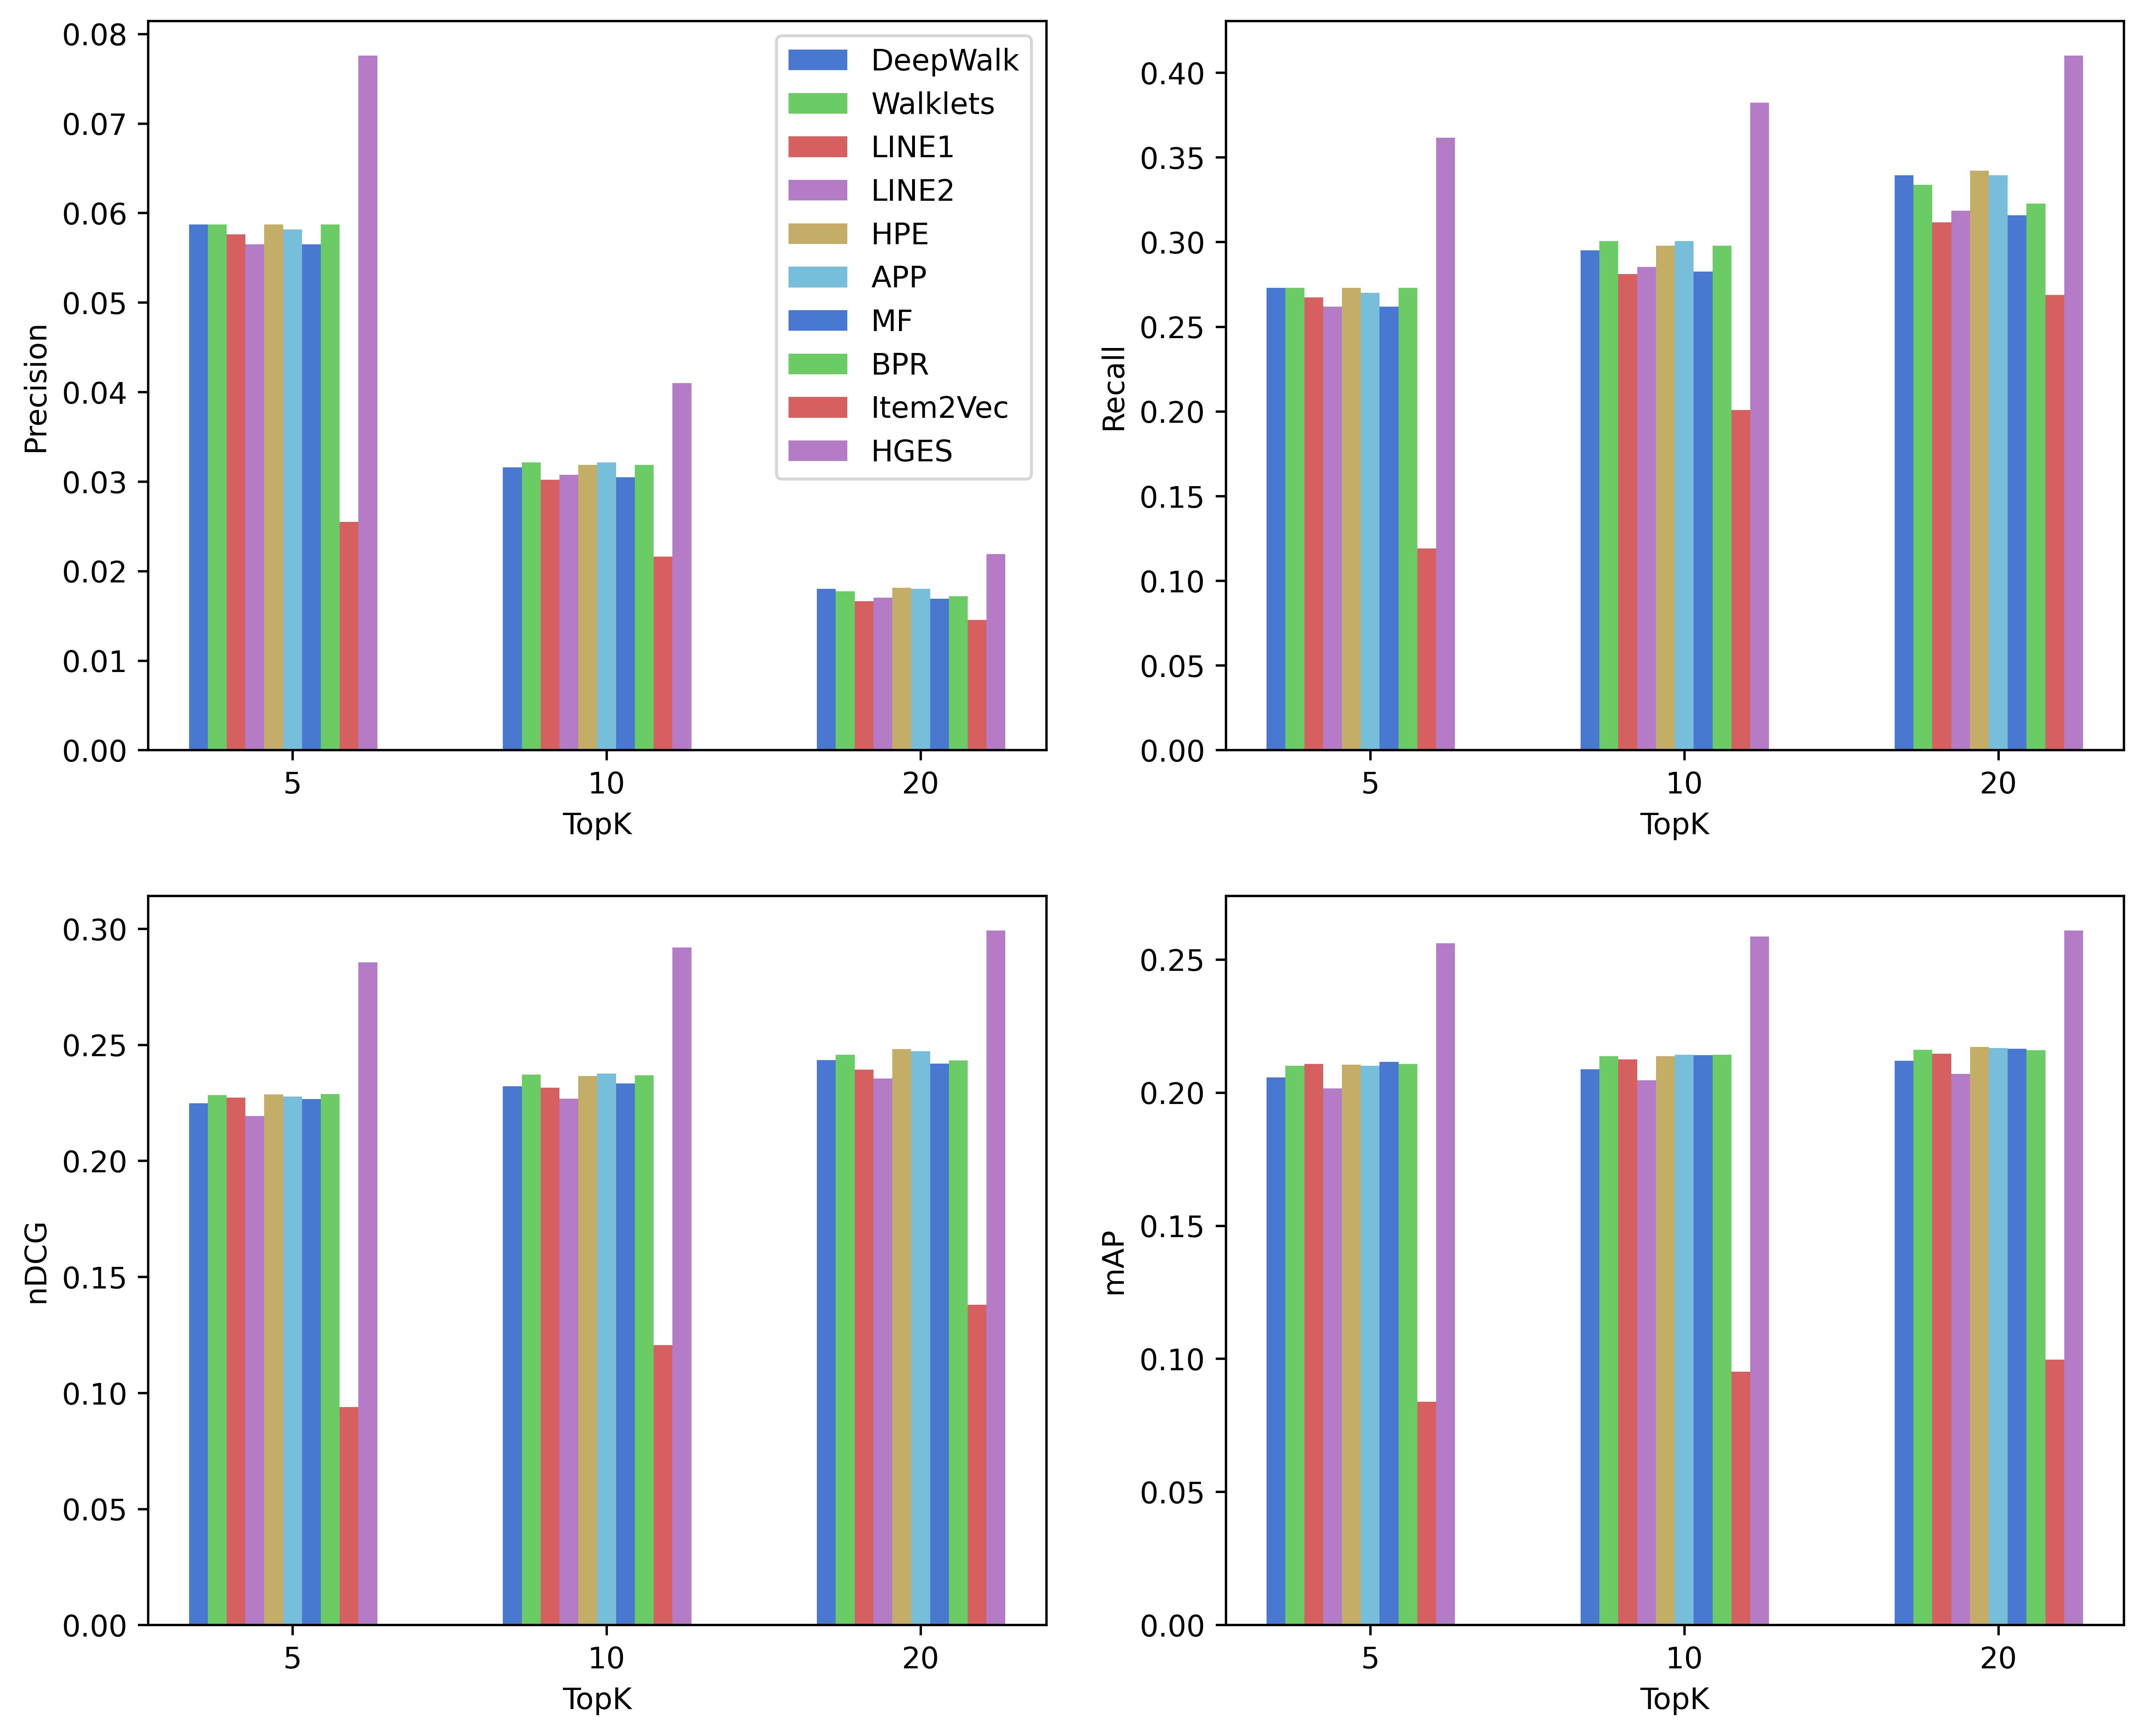

In [20]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# fig, ax = plt.subplots(1, 3)
fig = plt.figure(figsize=[12, 10], dpi=600)
ax = fig.subplots(nrows=2, ncols=2)

# precision
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
precision_at_5s = douban_concat_dataframe.loc[:, "precision_at_5"].to_list()
precision_at_10s = douban_concat_dataframe.loc[:, "precision_at_10"].to_list()
precision_at_20s = douban_concat_dataframe.loc[:, "precision_at_20"].to_list()

positions = np.arange(3)
width = 0.06
for i, algorithm in enumerate(algorithms):
    precisions = [precision_at_5s[i], precision_at_10s[i], precision_at_20s[i]]
    ax[0, 0].bar(positions+i*width, precisions, width, label=algorithm)
ax[0, 0].set_xticks(positions+len(algorithms)*width/2)
ax[0, 0].set_xticklabels(["5", "10", "20"])
ax[0, 0].set_xlabel("TopK")
ax[0, 0].set_ylabel("Precision")
ax[0, 0].legend(loc="best")

# recall
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
recall_at_5s = douban_concat_dataframe.loc[:, "recall_at_5"].to_list()
recall_at_10s = douban_concat_dataframe.loc[:, "recall_at_10"].to_list()
recall_at_20s = douban_concat_dataframe.loc[:, "recall_at_20"].to_list()

positions = np.arange(3)
width = 0.06
for i, algorithm in enumerate(algorithms):
    recalls = [recall_at_5s[i], recall_at_10s[i], recall_at_20s[i]]
    ax[0, 1].bar(positions+i*width, recalls, width, label=algorithm)
ax[0, 1].set_xticks(positions+len(algorithms)*width/2)
ax[0, 1].set_xticklabels(["5", "10", "20"])
ax[0, 1].set_xlabel("TopK")
ax[0, 1].set_ylabel("Recall")
# ax[0, 1].legend(loc="best")

# ndcg
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
ndcg_at_5s = douban_concat_dataframe.loc[:, "ndcg_at_5"].to_list()
ndcg_at_10s = douban_concat_dataframe.loc[:, "ndcg_at_10"].to_list()
ndcg_at_20s = douban_concat_dataframe.loc[:, "ndcg_at_20"].to_list()

positions = np.arange(3)
width = 0.06
for i, algorithm in enumerate(algorithms):
    ndcgs = [ndcg_at_5s[i], ndcg_at_10s[i], ndcg_at_20s[i]]
    ax[1, 0].bar(positions+i*width, ndcgs, width, label=algorithm)
ax[1, 0].set_xticks(positions+len(algorithms)*width/2)
ax[1, 0].set_xticklabels(["5", "10", "20"])
ax[1, 0].set_xlabel("TopK")
ax[1, 0].set_ylabel("nDCG")
# ax[1, 0].legend(loc="best")

# map
algorithms = douban_concat_dataframe.loc[:, "algorithm"].to_list()
map_at_5s = douban_concat_dataframe.loc[:, "map_at_5"].to_list()
map_at_10s = douban_concat_dataframe.loc[:, "map_at_10"].to_list()
map_at_20s = douban_concat_dataframe.loc[:, "map_at_20"].to_list()

positions = np.arange(3)
width = 0.06
for i, algorithm in enumerate(algorithms):
    maps = [map_at_5s[i], map_at_10s[i], map_at_20s[i]]
    ax[1, 1].bar(positions+i*width, maps, width, label=algorithm)
ax[1, 1].set_xticks(positions+len(algorithms)*width/2)
ax[1, 1].set_xticklabels(["5", "10", "20"])
ax[1, 1].set_xlabel("TopK")
ax[1, 1].set_ylabel("mAP")
# ax[1, 1].legend(loc="best")

fig.savefig('./images/evaluations.eps', dpi=600, format="eps")
fig.savefig("./images/evaluations.png", dpi=600, format="png")

#  Parameter Sensitivity and Convergence Analyses

In [21]:
douban_tuning = EvaluatePartition("../data/douban/baseline")

users: 361, events: 291


In [ ]:
# f = 64
# h = 256
# l = str(0.005)[2:]
# result_dir = "SAFMmp_ds/shared-attention/F{0}H{1}L{2}B256R001/0314".format(f, h, l)
# with elapsed_timer("{0}s - %s" % (result_dir,)):
#     for e in range(10, 100 + 1, 10):
#         result_path = os.path.join(result_dir, "SAFMsatt_F{0}H{1}L{2}B256E{3}R001.tsv".format(f, h, l, e))
#         with elapsed_timer("-- {0}s - %s" % (result_path,)):
#             frappe_safmsatt_ds_ni.add_evaluation(
#                 frappe_file(result_path),
#                 "partition", partition=e, algorithm="SAFMsatt_ds_ni", model_params="0314F{0}H{1}L{2}B256R001".format(f, h, l))

In [ ]:
# result_dir = "category2vec/number_walks10/walk_length40/representation_size64/window_size5/lambda_factor"
# # with elapsed_timer("-- {0}s - %s" % (result_dir,)):
# #     douban_proposed.add_evaluation(douban_file(result_dir, "deepwalk.tsv"), "partition", partition=1, algorithm="deepwalk", model_params="deepwalk")
# with elapsed_timer("-- {0}s - %s" % (result_dir,)):
#     douban_proposed.add_evaluation(douban_file(result_dir, "category2vec.tsv"), "partition", partition=1, algorithm="HGES", model_params="hges")

In [23]:
# for number_walks in [10, 40, 80]:  # walk_times
for number_walks in [10]:  # walk_times
    for walk_length in [40, 60, 80]:  # walk_steps
        for representation_size in [64, 128, 256, 512]:  # dimensions
            for window_size in [2, 3, 4, 5, 6, 8, 10]:  # window_size
                for lambda_factor in [0.0025, 0.01, 0.025, 0.1, 0.25, 1.0, 2.5, 10.0, 25.0]:
                    result_dir = "category2vec/number_walks{}/walk_length{}/representation_size{}/window_size{}/lambda_factor{}".format(
                        number_walks, walk_length, representation_size, window_size, lambda_factor)
                    with elapsed_timer("-- {0}s - %s" % (result_dir,)):
                        douban_tuning.add_evaluation(douban_file(result_dir, "category2vec.tsv"), "partition", partition=1, algorithm="HGES", model_params=result_dir)

-- 10.875055074691772s - category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.0025
-- 11.463890552520752s - category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.01
-- 11.741229772567749s - category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.025
-- 11.476041316986084s - category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.1
-- 11.373073816299438s - category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.25
-- 11.666589736938477s - category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor1.0
-- 11.513148784637451s - category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor2.5
-- 11.435135841369629s - category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor10.0
-- 11.56903076171875s - category2vec/num

-- 11.215925216674805s - category2vec/number_walks10/walk_length40/representation_size128/window_size2/lambda_factor2.5
-- 10.989587545394897s - category2vec/number_walks10/walk_length40/representation_size128/window_size2/lambda_factor10.0
-- 11.169434309005737s - category2vec/number_walks10/walk_length40/representation_size128/window_size2/lambda_factor25.0
-- 11.395217657089233s - category2vec/number_walks10/walk_length40/representation_size128/window_size3/lambda_factor0.0025
-- 11.514287948608398s - category2vec/number_walks10/walk_length40/representation_size128/window_size3/lambda_factor0.01
-- 11.085010528564453s - category2vec/number_walks10/walk_length40/representation_size128/window_size3/lambda_factor0.025
-- 11.131759881973267s - category2vec/number_walks10/walk_length40/representation_size128/window_size3/lambda_factor0.1
-- 11.11811375617981s - category2vec/number_walks10/walk_length40/representation_size128/window_size3/lambda_factor0.25
-- 11.114880800247192s - categor

-- 11.525397300720215s - category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor0.025
-- 11.377425909042358s - category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor0.1
-- 11.741118907928467s - category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor0.25
-- 11.282008647918701s - category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor1.0
-- 11.283894062042236s - category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor2.5
-- 11.214909315109253s - category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor10.0
-- 11.272926330566406s - category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor25.0
-- 11.171024322509766s - category2vec/number_walks10/walk_length40/representation_size256/window_size4/lambda_factor0.0025
-- 11.277278423309326s - categor

-- 11.335288286209106s - category2vec/number_walks10/walk_length40/representation_size512/window_size3/lambda_factor10.0
-- 11.19889235496521s - category2vec/number_walks10/walk_length40/representation_size512/window_size3/lambda_factor25.0
-- 11.23246955871582s - category2vec/number_walks10/walk_length40/representation_size512/window_size4/lambda_factor0.0025
-- 11.30764389038086s - category2vec/number_walks10/walk_length40/representation_size512/window_size4/lambda_factor0.01
-- 11.342939853668213s - category2vec/number_walks10/walk_length40/representation_size512/window_size4/lambda_factor0.025
-- 11.271165370941162s - category2vec/number_walks10/walk_length40/representation_size512/window_size4/lambda_factor0.1
-- 11.483289241790771s - category2vec/number_walks10/walk_length40/representation_size512/window_size4/lambda_factor0.25
-- 11.417475461959839s - category2vec/number_walks10/walk_length40/representation_size512/window_size4/lambda_factor1.0
-- 11.418402671813965s - category2

-- 11.425419330596924s - category2vec/number_walks10/walk_length60/representation_size64/window_size4/lambda_factor0.1
-- 11.30766773223877s - category2vec/number_walks10/walk_length60/representation_size64/window_size4/lambda_factor0.25
-- 11.320687770843506s - category2vec/number_walks10/walk_length60/representation_size64/window_size4/lambda_factor1.0
-- 11.012088060379028s - category2vec/number_walks10/walk_length60/representation_size64/window_size4/lambda_factor2.5
-- 11.084688663482666s - category2vec/number_walks10/walk_length60/representation_size64/window_size4/lambda_factor10.0
-- 11.392722845077515s - category2vec/number_walks10/walk_length60/representation_size64/window_size4/lambda_factor25.0
-- 11.302659034729004s - category2vec/number_walks10/walk_length60/representation_size64/window_size5/lambda_factor0.0025
-- 11.3553307056427s - category2vec/number_walks10/walk_length60/representation_size64/window_size5/lambda_factor0.01
-- 11.404090404510498s - category2vec/number

-- 11.255849123001099s - category2vec/number_walks10/walk_length60/representation_size128/window_size5/lambda_factor0.0025
-- 11.234186887741089s - category2vec/number_walks10/walk_length60/representation_size128/window_size5/lambda_factor0.01
-- 11.412893056869507s - category2vec/number_walks10/walk_length60/representation_size128/window_size5/lambda_factor0.025
-- 11.213888883590698s - category2vec/number_walks10/walk_length60/representation_size128/window_size5/lambda_factor0.1
-- 11.299521923065186s - category2vec/number_walks10/walk_length60/representation_size128/window_size5/lambda_factor0.25
-- 11.306625366210938s - category2vec/number_walks10/walk_length60/representation_size128/window_size5/lambda_factor1.0
-- 11.416697978973389s - category2vec/number_walks10/walk_length60/representation_size128/window_size5/lambda_factor2.5
-- 11.311306953430176s - category2vec/number_walks10/walk_length60/representation_size128/window_size5/lambda_factor10.0
-- 11.476342678070068s - categor

-- 11.53959059715271s - category2vec/number_walks10/walk_length60/representation_size256/window_size5/lambda_factor1.0
-- 11.39450478553772s - category2vec/number_walks10/walk_length60/representation_size256/window_size5/lambda_factor2.5
-- 11.47516918182373s - category2vec/number_walks10/walk_length60/representation_size256/window_size5/lambda_factor10.0
-- 11.345267534255981s - category2vec/number_walks10/walk_length60/representation_size256/window_size5/lambda_factor25.0
-- 11.481264114379883s - category2vec/number_walks10/walk_length60/representation_size256/window_size6/lambda_factor0.0025
-- 11.44722867012024s - category2vec/number_walks10/walk_length60/representation_size256/window_size6/lambda_factor0.01
-- 11.275553941726685s - category2vec/number_walks10/walk_length60/representation_size256/window_size6/lambda_factor0.025
-- 11.346752643585205s - category2vec/number_walks10/walk_length60/representation_size256/window_size6/lambda_factor0.1
-- 11.35144567489624s - category2vec

-- 11.344710111618042s - category2vec/number_walks10/walk_length60/representation_size512/window_size6/lambda_factor0.01
-- 11.294005393981934s - category2vec/number_walks10/walk_length60/representation_size512/window_size6/lambda_factor0.025
-- 11.186326026916504s - category2vec/number_walks10/walk_length60/representation_size512/window_size6/lambda_factor0.1
-- 11.05695915222168s - category2vec/number_walks10/walk_length60/representation_size512/window_size6/lambda_factor0.25
-- 11.135980129241943s - category2vec/number_walks10/walk_length60/representation_size512/window_size6/lambda_factor1.0
-- 11.290871620178223s - category2vec/number_walks10/walk_length60/representation_size512/window_size6/lambda_factor2.5
-- 11.261822700500488s - category2vec/number_walks10/walk_length60/representation_size512/window_size6/lambda_factor10.0
-- 11.423215627670288s - category2vec/number_walks10/walk_length60/representation_size512/window_size6/lambda_factor25.0
-- 11.474153518676758s - category2v

-- 11.194929361343384s - category2vec/number_walks10/walk_length80/representation_size64/window_size6/lambda_factor10.0
-- 11.275685787200928s - category2vec/number_walks10/walk_length80/representation_size64/window_size6/lambda_factor25.0
-- 11.237870454788208s - category2vec/number_walks10/walk_length80/representation_size64/window_size8/lambda_factor0.0025
-- 11.430895566940308s - category2vec/number_walks10/walk_length80/representation_size64/window_size8/lambda_factor0.01
-- 11.25168251991272s - category2vec/number_walks10/walk_length80/representation_size64/window_size8/lambda_factor0.025
-- 11.28047800064087s - category2vec/number_walks10/walk_length80/representation_size64/window_size8/lambda_factor0.1
-- 11.336569786071777s - category2vec/number_walks10/walk_length80/representation_size64/window_size8/lambda_factor0.25
-- 11.112953662872314s - category2vec/number_walks10/walk_length80/representation_size64/window_size8/lambda_factor1.0
-- 11.256521701812744s - category2vec/num

-- 11.199699878692627s - category2vec/number_walks10/walk_length80/representation_size128/window_size8/lambda_factor0.1
-- 11.231724977493286s - category2vec/number_walks10/walk_length80/representation_size128/window_size8/lambda_factor0.25
-- 11.23296570777893s - category2vec/number_walks10/walk_length80/representation_size128/window_size8/lambda_factor1.0
-- 11.226974487304688s - category2vec/number_walks10/walk_length80/representation_size128/window_size8/lambda_factor2.5
-- 11.408299684524536s - category2vec/number_walks10/walk_length80/representation_size128/window_size8/lambda_factor10.0
-- 10.64854383468628s - category2vec/number_walks10/walk_length80/representation_size128/window_size8/lambda_factor25.0
-- 11.308241367340088s - category2vec/number_walks10/walk_length80/representation_size128/window_size10/lambda_factor0.0025
-- 11.354005098342896s - category2vec/number_walks10/walk_length80/representation_size128/window_size10/lambda_factor0.01
-- 11.373380184173584s - category

-- 11.044596195220947s - category2vec/number_walks10/walk_length80/representation_size256/window_size8/lambda_factor25.0
-- 11.236361503601074s - category2vec/number_walks10/walk_length80/representation_size256/window_size10/lambda_factor0.0025
-- 11.609261512756348s - category2vec/number_walks10/walk_length80/representation_size256/window_size10/lambda_factor0.01
-- 11.05541729927063s - category2vec/number_walks10/walk_length80/representation_size256/window_size10/lambda_factor0.025
-- 11.150002241134644s - category2vec/number_walks10/walk_length80/representation_size256/window_size10/lambda_factor0.1
-- 11.36689305305481s - category2vec/number_walks10/walk_length80/representation_size256/window_size10/lambda_factor0.25
-- 11.648778915405273s - category2vec/number_walks10/walk_length80/representation_size256/window_size10/lambda_factor1.0
-- 11.506681680679321s - category2vec/number_walks10/walk_length80/representation_size256/window_size10/lambda_factor2.5
-- 11.487484455108643s - ca

-- 11.170031785964966s - category2vec/number_walks10/walk_length80/representation_size512/window_size10/lambda_factor0.25
-- 11.092484712600708s - category2vec/number_walks10/walk_length80/representation_size512/window_size10/lambda_factor1.0
-- 11.174603700637817s - category2vec/number_walks10/walk_length80/representation_size512/window_size10/lambda_factor2.5
-- 11.583930969238281s - category2vec/number_walks10/walk_length80/representation_size512/window_size10/lambda_factor10.0
-- 11.373027324676514s - category2vec/number_walks10/walk_length80/representation_size512/window_size10/lambda_factor25.0


In [29]:
#显示所有列
pd.set_option('display.max_columns', None)
#显示所有行
pd.set_option('display.max_rows', None)
#设置value的显示长度为100，默认为50
pd.set_option('max_colwidth',100)

In [30]:
douban_proposed.group_evaluations["partition"]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.009861,0.021884,0.040997,0.077562,0.465374,0.409972,0.382271,0.361496,0.019314,0.041549,0.074053,0.127721,0.309934,0.299201,0.291898,0.285456,0.260818,0.258657,0.256094,14.915842,0.0,1.0,1.0,0.469816,1,HGES,hges
1,0.009695,0.020914,0.039335,0.073130,0.457064,0.390582,0.365651,0.340720,0.018988,0.039702,0.071029,0.120415,0.305205,0.292088,0.285644,0.277129,0.258402,0.256559,0.252608,17.703883,0.0,1.0,1.0,0.459318,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.0025
2,0.009695,0.021468,0.040443,0.074238,0.454294,0.401662,0.376731,0.346260,0.018985,0.040758,0.073045,0.122263,0.300057,0.289630,0.283436,0.273092,0.251697,0.250049,0.245522,17.497585,0.0,1.0,1.0,0.456693,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.01
3,0.010249,0.022715,0.041551,0.074792,0.483380,0.426593,0.387812,0.347645,0.020073,0.043133,0.075060,0.123101,0.310219,0.298836,0.289338,0.276252,0.257017,0.254572,0.249077,14.625000,0.0,1.0,1.0,0.454068,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.025
4,0.009252,0.021191,0.040720,0.073684,0.433518,0.396122,0.380886,0.343490,0.018117,0.040230,0.073575,0.121339,0.309022,0.301535,0.297556,0.285354,0.268521,0.267319,0.262096,17.135000,0.0,1.0,1.0,0.475066,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.1
5,0.009474,0.020914,0.038781,0.071468,0.443213,0.390582,0.361496,0.331025,0.018551,0.039702,0.070048,0.117556,0.303511,0.293182,0.285942,0.275988,0.260409,0.258459,0.254294,18.592233,0.0,1.0,1.0,0.459318,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.25
6,0.009695,0.020914,0.039335,0.073130,0.457064,0.390582,0.365651,0.340720,0.018988,0.039702,0.071029,0.120415,0.305205,0.292088,0.285644,0.277129,0.258402,0.256559,0.252608,17.703883,0.0,1.0,1.0,0.459318,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.0025
7,0.009695,0.021468,0.040443,0.074238,0.454294,0.401662,0.376731,0.346260,0.018985,0.040758,0.073045,0.122263,0.300057,0.289630,0.283436,0.273092,0.251697,0.250049,0.245522,17.497585,0.0,1.0,1.0,0.456693,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.01
8,0.010249,0.022715,0.041551,0.074792,0.483380,0.426593,0.387812,0.347645,0.020073,0.043133,0.075060,0.123101,0.310219,0.298836,0.289338,0.276252,0.257017,0.254572,0.249077,14.625000,0.0,1.0,1.0,0.454068,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.025
9,0.009252,0.021191,0.040720,0.073684,0.433518,0.396122,0.380886,0.343490,0.018117,0.040230,0.073575,0.121339,0.309022,0.301535,0.297556,0.285354,0.268521,0.267319,0.262096,17.135000,0.0,1.0,1.0,0.475066,1,HGES,category2vec/number_walks10/walk_length40/representation_size64/window_size2/lambda_factor0.1


In [26]:
douban_tuning_dataframe = douban_proposed.group_evaluations["partition"]
douban_tuning_dataframe[douban_tuning_dataframe.loc[:, "ndcg_at_10"] == douban_tuning_dataframe.loc[:, "ndcg_at_10"].max()]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
148,0.009751,0.021745,0.041274,0.076454,0.458449,0.407202,0.385042,0.355956,0.019095,0.041286,0.074556,0.125873,0.326343,0.316161,0.310562,0.300971,0.284523,0.282983,0.278855,19.597222,0.0,1.0,1.0,0.433071,1,HGES,category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor10.0


findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


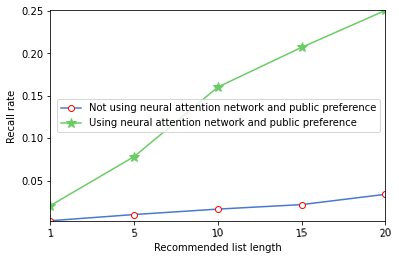

In [61]:
# import matplotlib.pyplot as plt
# from pylab import *                                 #支持中文

# '''
# 折线图（Point-1）- Recall rate
# '''
# mpl.rcParams['font.sans-serif'] = ['SimHei']

# names = ['1', '5', '10', '15', '20']
# x = range(len(names))
# y = [0.0206, 0.0765, 0.1264, 0.1928, 0.2446]
# y1 = [0.0658, 0.1837, 0.3358, 0.4274, 0.5013]
# y_dataset2 = [0.0026, 0.0099, 0.0163, 0.0216, 0.0337]
# y1_dataset2 = [0.0205, 0.0782, 0.1601, 0.2069, 0.2504]
# # plt.plot(x, y, 'ro-')
# # plt.plot(x, y1, 'bo-')
# # pl.xlim(-1, 11)  # 限定横轴的范围
# # pl.ylim(-1, 110)  # 限定纵轴的范围
# plt.plot(x, y_dataset2, marker='o', mec='r', mfc='w', label=u'Not using neural attention network and public preference')
# plt.plot(x, y1_dataset2, marker='*', ms=10, label=u'Using neural attention network and public preference')
# plt.legend()  # 让图例生效
# plt.xticks(x, names, rotation=5)
# plt.margins(0)
# plt.subplots_adjust(bottom=0.15)
# plt.xlabel("Recommended list length") #X轴标签
# plt.ylabel("Recall rate") #Y轴标签
# # plt.title("A simple plot") #标题

# plt.show()

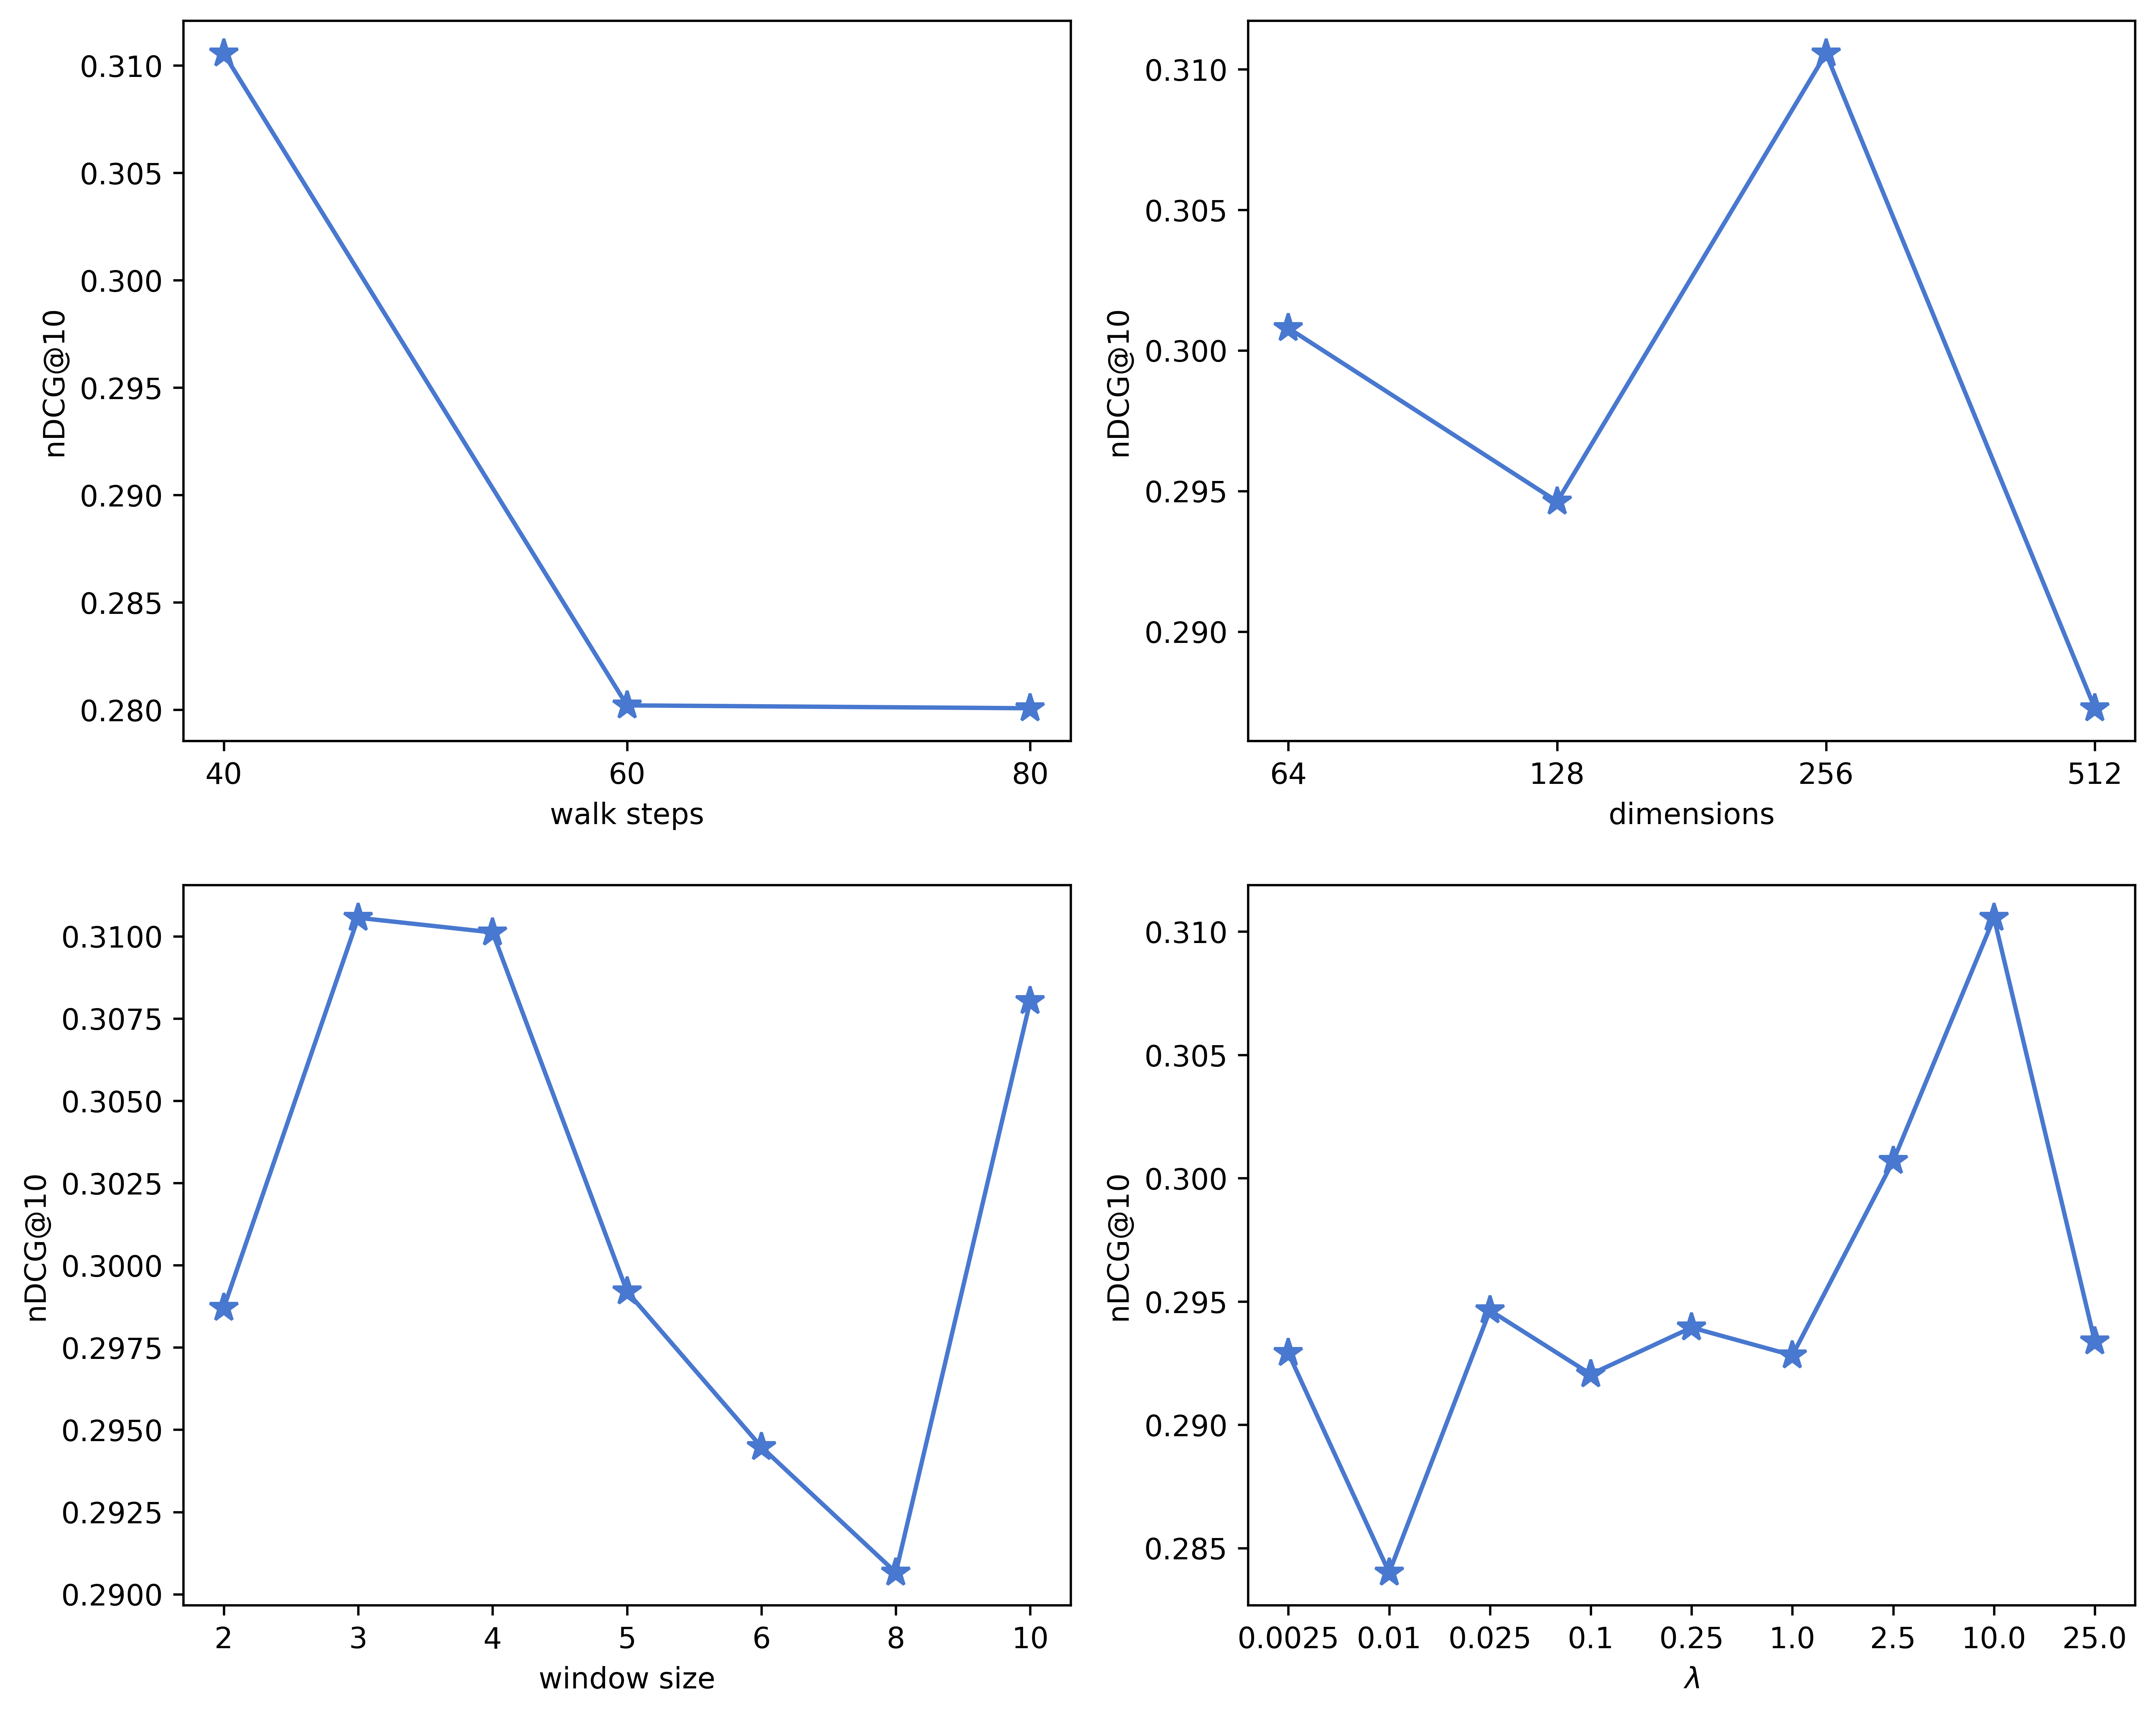

In [76]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# fig, ax = plt.subplots(1, 3)
fig = plt.figure(figsize=[12, 10], dpi=600)
ax = fig.subplots(nrows=2, ncols=2)

# walk length
num_walks = 10
walk_length_list = [40, 60, 80]
representation_size = 256
window_size = 3
lambda_factor = 10.0
ndcg_at_10s = []
for walk_length in walk_length_list:
    result_dir = "category2vec/number_walks{}/walk_length{}/representation_size{}/window_size{}/lambda_factor{}".format(
        num_walks, walk_length, representation_size, window_size, lambda_factor)
    ndcg_at_10s.append(douban_tuning_dataframe[douban_tuning_dataframe.loc[:, "model_params"] == result_dir].reset_index().at[0, "ndcg_at_10"])

x = range(len(walk_length_list))
ax[0, 0].plot(x, ndcg_at_10s, marker='*', ms=10)
# plt.xticks(x, walk_lengths)
ax[0, 0].set_xticks(x)
ax[0, 0].set_xticklabels(walk_length_list)
ax[0, 0].set_xlabel("walk steps") #X轴标签
ax[0, 0].set_ylabel("nDCG@10") #Y轴标签
# ax[0, 0].set_ylim(0, 0.32)

# representation_size
num_walks = 10
walk_length = 40
representation_size_list = [64, 128, 256, 512]
window_size = 3
lambda_factor = 10.0
ndcg_at_10s = []
for representation_size in representation_size_list:
    result_dir = "category2vec/number_walks{}/walk_length{}/representation_size{}/window_size{}/lambda_factor{}".format(
        num_walks, walk_length, representation_size, window_size, lambda_factor)
    ndcg_at_10s.append(douban_tuning_dataframe[douban_tuning_dataframe.loc[:, "model_params"] == result_dir].reset_index().at[0, "ndcg_at_10"])

x = range(len(representation_size_list))
ax[0, 1].plot(x, ndcg_at_10s, marker='*', ms=10)
ax[0, 1].set_xticks(x)
ax[0, 1].set_xticklabels(representation_size_list)
ax[0, 1].set_xlabel("dimensions") #X轴标签
ax[0, 1].set_ylabel("nDCG@10") #Y轴标签

# window_size
num_walks = 10
walk_length = 40
representation_size = 256
window_size_list = [2, 3, 4, 5, 6, 8, 10]
lambda_factor = 10.0
ndcg_at_10s = []
for window_size in window_size_list:
    result_dir = "category2vec/number_walks{}/walk_length{}/representation_size{}/window_size{}/lambda_factor{}".format(
        num_walks, walk_length, representation_size, window_size, lambda_factor)
    ndcg_at_10s.append(douban_tuning_dataframe[douban_tuning_dataframe.loc[:, "model_params"] == result_dir].reset_index().at[0, "ndcg_at_10"])

x = range(len(window_size_list))
ax[1, 0].plot(x, ndcg_at_10s, marker='*', ms=10)
ax[1, 0].set_xticks(x)
ax[1, 0].set_xticklabels(window_size_list)
ax[1, 0].set_xlabel("window size") #X轴标签
ax[1, 0].set_ylabel("nDCG@10") #Y轴标签

# lambda_factor
num_walks = 10
walk_length = 40
representation_size = 256
window_size = 3
lambda_factor_list = [0.0025, 0.01, 0.025, 0.1, 0.25, 1.0, 2.5, 10.0, 25.0]
ndcg_at_10s = []
for lambda_factor in lambda_factor_list:
    result_dir = "category2vec/number_walks{}/walk_length{}/representation_size{}/window_size{}/lambda_factor{}".format(
        num_walks, walk_length, representation_size, window_size, lambda_factor)
    ndcg_at_10s.append(douban_tuning_dataframe[douban_tuning_dataframe.loc[:, "model_params"] == result_dir].reset_index().at[0, "ndcg_at_10"])

x = range(len(lambda_factor_list))
ax[1, 1].plot(x, ndcg_at_10s, marker='*', ms=10)
ax[1, 1].set_xticks(x)
ax[1, 1].set_xticklabels(lambda_factor_list)
ax[1, 1].set_xlabel("$\lambda$") #X轴标签
ax[1, 1].set_ylabel("nDCG@10") #Y轴标签

fig.savefig('./images/parameter_sensitivity.eps', dpi=600, format="eps")
fig.savefig("./images/parametersensitivity.png", dpi=600, format="png")

In [87]:
douban_tuning = EvaluatePartition("../data/douban/baseline")

users: 361, events: 291


In [98]:
for number_walks in [10, 20, 40, 60, 80, 100]:  # walk_times
    for walk_length in [40]:  # walk_steps
        for representation_size in [256]:  # dimensions
            for window_size in [3]:  # window_size
                for lambda_factor in [10.0]:
                    result_dir = "category2vec/number_walks{}/walk_length{}/representation_size{}/window_size{}/lambda_factor{}".format(
                        number_walks, walk_length, representation_size, window_size, lambda_factor)
                    with elapsed_timer("-- {0}s - %s" % (result_dir,)):
                        douban_tuning.add_evaluation(douban_file(result_dir, "category2vec.tsv"), "partition", partition=1, algorithm="HGES", model_params=result_dir)

-- 10.938807010650635s - category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor10.0
-- 11.595935821533203s - category2vec/number_walks20/walk_length40/representation_size256/window_size3/lambda_factor10.0
-- 11.493460893630981s - category2vec/number_walks40/walk_length40/representation_size256/window_size3/lambda_factor10.0
-- 11.744899988174438s - category2vec/number_walks60/walk_length40/representation_size256/window_size3/lambda_factor10.0
-- 11.292807579040527s - category2vec/number_walks80/walk_length40/representation_size256/window_size3/lambda_factor10.0
-- 11.322263717651367s - category2vec/number_walks100/walk_length40/representation_size256/window_size3/lambda_factor10.0


In [99]:
douban_tuning.group_evaluations["partition"]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.009751,0.021745,0.041274,0.076454,0.458449,0.407202,0.385042,0.355956,0.019095,0.041286,0.074556,0.125873,0.326343,0.316161,0.310562,0.300971,0.284523,0.282983,0.278855,19.597222,0.0,1.0,1.0,0.433071,1,HGES,category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor10.0
1,0.009529,0.021330,0.039612,0.073130,0.447368,0.398892,0.369806,0.340720,0.018661,0.040494,0.071559,0.120415,0.308607,0.299051,0.291756,0.282433,0.265523,0.263542,0.259626,16.547264,0.0,1.0,1.0,0.472441,1,HGES,category2vec/number_walks20/walk_length40/representation_size256/window_size3/lambda_factor10.0
2,0.009030,0.019945,0.037396,0.072022,0.418283,0.372576,0.347645,0.333795,0.017679,0.037862,0.067528,0.118480,0.289190,0.279961,0.273571,0.269000,0.247437,0.245640,0.243698,16.378947,0.0,1.0,1.0,0.501312,1,HGES,category2vec/number_walks40/walk_length40/representation_size256/window_size3/lambda_factor10.0
3,0.009030,0.020083,0.038227,0.067036,0.419668,0.372576,0.354571,0.310249,0.017680,0.038112,0.069014,0.110250,0.291661,0.282357,0.277852,0.263526,0.251303,0.250032,0.244114,18.113402,0.0,1.0,1.0,0.490814,1,HGES,category2vec/number_walks80/walk_length40/representation_size256/window_size3/lambda_factor10.0
4,0.009751,0.021745,0.041274,0.076454,0.458449,0.407202,0.385042,0.355956,0.019095,0.041286,0.074556,0.125873,0.326343,0.316161,0.310562,0.300971,0.284523,0.282983,0.278855,19.597222,0.0,1.0,1.0,0.433071,1,HGES,category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor10.0
5,0.009529,0.021330,0.039612,0.073130,0.447368,0.398892,0.369806,0.340720,0.018661,0.040494,0.071559,0.120415,0.308607,0.299051,0.291756,0.282433,0.265523,0.263542,0.259626,16.547264,0.0,1.0,1.0,0.472441,1,HGES,category2vec/number_walks20/walk_length40/representation_size256/window_size3/lambda_factor10.0
6,0.009030,0.019945,0.037396,0.072022,0.418283,0.372576,0.347645,0.333795,0.017679,0.037862,0.067528,0.118480,0.289190,0.279961,0.273571,0.269000,0.247437,0.245640,0.243698,16.378947,0.0,1.0,1.0,0.501312,1,HGES,category2vec/number_walks40/walk_length40/representation_size256/window_size3/lambda_factor10.0
7,0.009197,0.019668,0.038227,0.071468,0.427978,0.365651,0.355956,0.331025,0.018006,0.037327,0.069040,0.117556,0.297783,0.285294,0.282738,0.275033,0.256026,0.255340,0.252378,17.704082,0.0,1.0,1.0,0.485564,1,HGES,category2vec/number_walks60/walk_length40/representation_size256/window_size3/lambda_factor10.0
8,0.009030,0.020083,0.038227,0.067036,0.419668,0.372576,0.354571,0.310249,0.017680,0.038112,0.069014,0.110250,0.291661,0.282357,0.277852,0.263526,0.251303,0.250032,0.244114,18.113402,0.0,1.0,1.0,0.490814,1,HGES,category2vec/number_walks80/walk_length40/representation_size256/window_size3/lambda_factor10.0
9,0.008975,0.019668,0.038504,0.068144,0.416898,0.365651,0.357341,0.314404,0.017572,0.037327,0.069518,0.112011,0.298121,0.287771,0.285673,0.271733,0.260330,0.259759,0.253924,16.232804,0.0,1.0,1.0,0.503937,1,HGES,category2vec/number_walks100/walk_length40/representation_size256/window_size3/lambda_factor10.0


In [100]:
douban_tuning_dataframe = douban_tuning.group_evaluations["partition"]
douban_tuning_dataframe[douban_tuning_dataframe.loc[:, "ndcg_at_10"] == douban_tuning_dataframe.loc[:, "ndcg_at_10"].max()]

,precision_at_50,precision_at_20,precision_at_10,precision_at_5,recall_at_50,recall_at_20,recall_at_10,recall_at_5,f1_score_at_50,f1_score_at_20,f1_score_at_10,f1_score_at_5,ndcg_at_50,ndcg_at_20,ndcg_at_10,ndcg_at_5,map_at_20,map_at_10,map_at_5,mean_ranks,user_coverage,event_coverage_at_10,event_coverage_at_20,perc_user_events_rank_NA,partition,algorithm,model_params
0,0.009751,0.021745,0.041274,0.076454,0.458449,0.407202,0.385042,0.355956,0.019095,0.041286,0.074556,0.125873,0.326343,0.316161,0.310562,0.300971,0.284523,0.282983,0.278855,19.597222,0.0,1.0,1.0,0.433071,1,HGES,category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor10.0
4,0.009751,0.021745,0.041274,0.076454,0.458449,0.407202,0.385042,0.355956,0.019095,0.041286,0.074556,0.125873,0.326343,0.316161,0.310562,0.300971,0.284523,0.282983,0.278855,19.597222,0.0,1.0,1.0,0.433071,1,HGES,category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor10.0


category2vec/number_walks10/walk_length40/representation_size256/window_size3/lambda_factor10.0
category2vec/number_walks20/walk_length40/representation_size256/window_size3/lambda_factor10.0
category2vec/number_walks40/walk_length40/representation_size256/window_size3/lambda_factor10.0
category2vec/number_walks60/walk_length40/representation_size256/window_size3/lambda_factor10.0
category2vec/number_walks80/walk_length40/representation_size256/window_size3/lambda_factor10.0
category2vec/number_walks100/walk_length40/representation_size256/window_size3/lambda_factor10.0


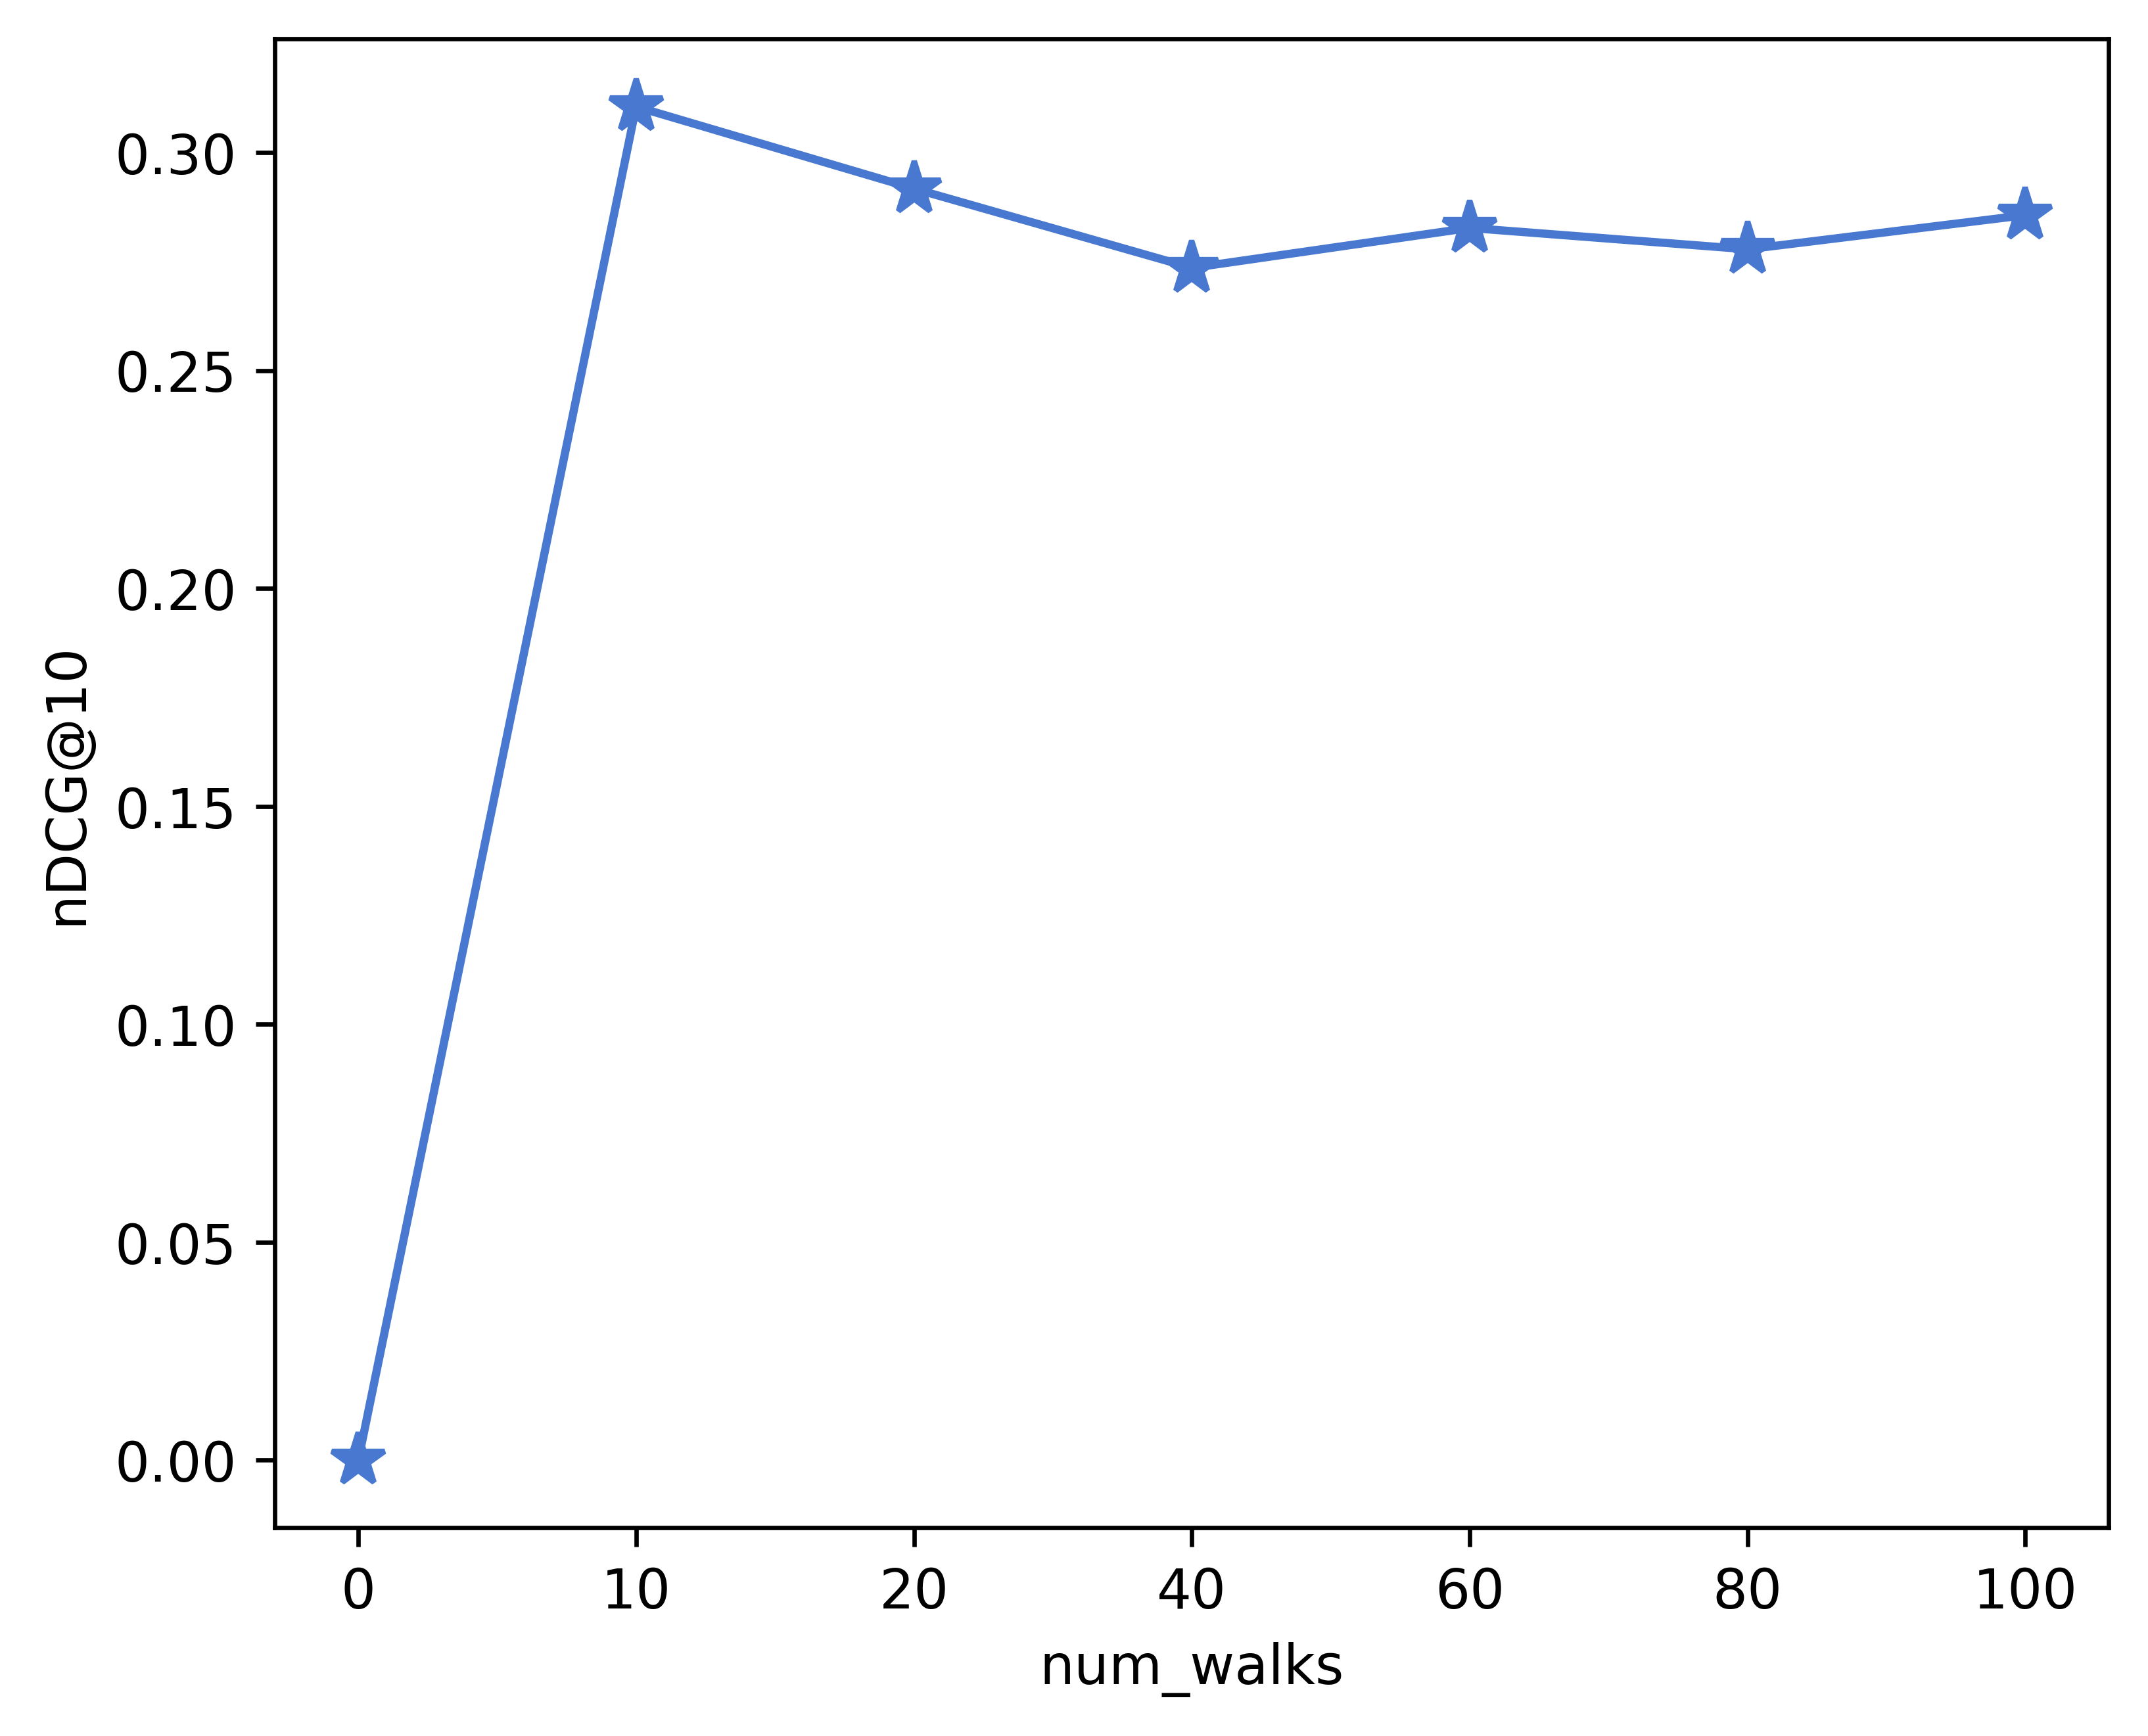

In [103]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.style.use('seaborn-muted')
# fig, ax = plt.subplots(1, 3)
fig = plt.figure(figsize=[6, 5], dpi=600)
ax = fig.subplots(nrows=1, ncols=1)

# num_walks
num_walks_list = [10, 20, 40, 60, 80, 100]
walk_length = 40
representation_size = 256
window_size = 3
lambda_factor = 10.0
ndcg_at_10s = [0]
for num_walks in num_walks_list:
    result_dir = "category2vec/number_walks{}/walk_length{}/representation_size{}/window_size{}/lambda_factor{}".format(
        num_walks, walk_length, representation_size, window_size, lambda_factor)
    print(result_dir)
    ndcg_at_10s.append(douban_tuning_dataframe[douban_tuning_dataframe.loc[:, "model_params"] == result_dir].reset_index().at[0, "ndcg_at_10"])

x = range(len(num_walks_list)+1)
ax.plot(x, ndcg_at_10s, marker='*', ms=10)
# plt.xticks(x, walk_lengths)
ax.set_xticks(x)
ax.set_xticklabels([0]+num_walks_list)
ax.set_xlabel("num_walks") #X轴标签
ax.set_ylabel("nDCG@10") #Y轴标签
# ax[0, 0].set_ylim(0, 0.32)

fig.savefig('./images/parameter_sensitivity2.eps', dpi=600, format="eps")
fig.savefig("./images/parametersensitivity2.png", dpi=600, format="png")